In [2]:
!pip install cvxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.3 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/Users/qinshaofeng/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [164]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import cvxopt
import time
cvxopt.solvers.options['show_progress'] = False
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [241]:
def train_svm(X, y, C):
    """
    Argument:
      X: train_data: N*D matrix, each row as a sample and each column as a feature
      y: train_label: N*1 vector, each row as a label
      C: tradeoff parameter (on slack variable side)
    Return:
      w: feature vector (column vector)
      b: bias term
    """
    m, n = X.shape
    # print(y.shape)
    # print(X.shape)
    # transform to float
    y = y.reshape(-1,1)*(1.0)
    
    
    # compute H = y*X X^T y^T
    X_composed = y*X
    H = np.dot(X_composed, X_composed.T)*(1.0)
    
    # compute P, q, G, h, A, b for cvxopt formation
    P = cvxopt.matrix(H)
    
    q = cvxopt.matrix(-np.ones((m,1)))
    

    G = cvxopt.matrix(np.vstack((np.eye(m),np.eye(m)*(-1))))
    h = cvxopt.matrix(np.hstack((np.ones(m)*C, np.zeros(m))))
    
    A = cvxopt.matrix(y.reshape(1,-1))
    
    b = cvxopt.matrix(np.zeros(1))
    
    # define the quadratic solver
    # print(len(A))
    #print(X.shape())
    
    solution = cvxopt_solvers.qp(P, q , G, h, A, b)
    
    alphas = np.array(solution['x'])

    
    
    w = ((y*alphas).T @ X).reshape(-1,1)
    # set up threshold
    idx = (alphas > 1e-4).flatten()
    b = y[idx] - np.dot(X[idx], w)

    return w, b[0]


def test_svm(test_data, test_label, w, b):
    """
    Argument:
      test_data: M*D matrix, each row as a sample and each column as a feature
      test_label: M*1 vector, each row as a label
      w: feature vector
      b: bias term
    Return:
      test_accuracy: a float between [0, 1] representing the test accuracy
    """
    m = np.size(test_data, 0)
    count = 0
    
    for i in range(m):
        prediction = (test_data[i, :].dot(w)) + b
        if prediction >= 0:
            label = 1.0
        else:
            label = -1.0
        if label == test_label[i]:
            count += 1
        else:
            count += 0
    accuracy = count / np.size(test_label)
  
    return accuracy







In [242]:
# load data via path
train_data_path = "/Users/qinshaofeng/desktop/hw4_data/train_data.txt"
train_label_path = "/Users/qinshaofeng/desktop/hw4_data/train_label.txt"
test_data_path = "/Users/qinshaofeng/desktop/hw4_data/test_data.txt"
test_label_path = "/Users/qinshaofeng/desktop/hw4_data/test_label.txt"

train_data = np.genfromtxt(train_data_path)
train_label = np.genfromtxt(train_label_path)
test_data = np.genfromtxt(test_data_path)
test_label = np.genfromtxt(test_label_path)

In [243]:
print(len(train_data), len(train_data[0]))

1000 60


In [244]:
print(len(test_data), len(test_data[0]))
print(test_label[:200])

2175 60
[-1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.
  1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.
 -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1.
 -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.
 -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.
 -1. -1.]


In [245]:
def preprocessing(train_data, test_data):
    train_size, feature_size = len(train_data), len(train_data[0])
    test_size, _ = len(test_data), len(test_data[0])

    standardlized_train, standardlized_test = np.zeros((train_size, feature_size)), np.zeros((test_size, feature_size))

    sum_train = np.zeros(feature_size)

    avg_train = np.zeros(feature_size)


    for i in range(feature_size):
        for j in range(train_size):
            sum_train[i] += train_data[j, i]
            
    avg_train = sum_train/train_size


    std_train = np.zeros(feature_size)
    std_test = np.zeros(feature_size)
    diff_train = np.zeros(feature_size)
    diff_test = np.zeros(feature_size)

    for i in range(feature_size):
        for j in range(train_size):
            diff_train[i] += (train_data[j, i] - avg_train[i])**2
        # standard deviation for train feature i
        std_train[i] = (diff_train[i] / (train_size - 1))**(1/2)
    
    for i in range(feature_size):
        for j in range(test_size):
            diff_test[i] += (test_data[j, i] - avg_train[i])**2
        # standard deviation for test feature i
        std_test[i] = (diff_test[i] / (test_size - 1))**(1/2)
    
    #transform train ds and test ds with std, and med

    for i in range(train_size):
        for j in range(feature_size):
            standardlized_train[i][j] = (train_data[i][j] - avg_train[j])/std_train[j]
        
        
    for i in range(test_size):
        for j in range(feature_size):
            standardlized_test[i][j] = (test_data[i][j] - avg_train[j])/std_train[j]
            
    print("3rd mean = ", avg_train[2])
    print("3rd standard deviation = ", std_train[2])
    print("10nd mean = ", avg_train[9])
    print("10nd mean = ", std_train[9])
        

    return standardlized_train, standardlized_test
        
        


In [291]:
standardlized_train, standardlized_test = preprocessing(train_data, test_data)

3rd mean =  2.54
3rd standard deviation =  1.0749676997731392
10nd mean =  2.527
10nd mean =  1.1245156893238686


The mean and standard deviation should be estimated from the training data and then applied to both datasets, because we train or build the model on train dataset not the test dataset, so we should realy summary statistics like mean or std based only on training dataset, and apply the parameters and model to the test dataset later for prediction or evaluation.

In [286]:
standardlized_train, standardlized_test = preprocessing(train_data, test_data)
#print(len(standardlized_train), len(standardlized_train[0]))
#print(len(standardlized_test), len(standardlized_test[0]))
C = 4**(8)
w,b = train_svm(standardlized_train, train_label, C)


3rd mean =  2.54
3rd standard deviation =  1.0749676997731392
10nd mean =  2.527
10nd mean =  1.1245156893238686


In [287]:
test_svm(standardlized_test, test_label, w, b)

0.623448275862069

In [254]:
# using k fold

def kfold_cross(train_data, train_label, K, C):
    region = train_data.shape[0]//K
    acc = [0]*K
    for i in range(K):
        skip = np.arange(region*i, region*(i+1))
        train_data_copy, train_label_copy = train_data, train_label
        # delete the corresponding region
        train_data_ds = np.delete(train_data_copy, skip, axis = 0)
        train_label_ds = np.delete(train_label_copy, skip, axis = 0)
        val_data_ds = train_data[region*i : region*(i+1)]
        val_label_ds = train_label[region*i : region*(i+1)]
        w,b = train_svm(train_data_ds, train_label_ds, C)
        acc[i] = test_svm(val_data_ds, val_label_ds, w, b)
        
    return np.sum(acc)/K
        
    

[0.501, 0.788, 0.781, 0.751, 0.774, 0.781, 0.784, 0.7849999999999999, 0.784, 0.784, 0.784, 0.784, 0.765]


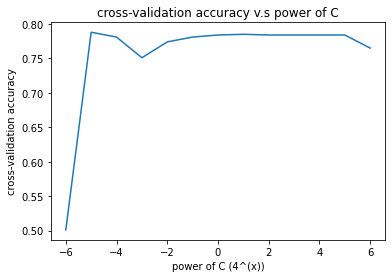

In [258]:

K = 5
acc_list = []
C_list = [4 ** (i-6) for i in range(13)]

for C in C_list:
    acc = kfold_cross(train_data, train_label, K, C)
    acc_list.append(acc)
    
print("the 5-fold cross-validation accuracy (averaged accuracy over each validation set) on different value of C is: ", acc_list)
x = [(i-6) for i in range(13)]
y = acc_list
plt.plot(x,y)
plt.xlabel("power of C (4^(x))")
plt.ylabel("cross-validation accuracy")
plt.title("cross-validation accuracy v.s power of C")
plt.show()

In [289]:
C = 4**10
kfold_cross(train_data, train_label, K, C)

0.728

(a) For initial small C (power of -6), the accuracy is low, and when we increase to 4^(-5), the accuracy significantly increases to 0.788,
and for larger C, the cross-validation accuracy oscillates and start droping when we increase power to 6. And I tried even larger power, and proved it will drop to 0.728 for C = 4^10. The accuracies are shown above.

The reason behind this is if we choose too large C, we add heavier penalization on outliers(harder boundary) and for non linear separable dataset, this will cause mis-classification on some instances and decreases the accuracy.

However, if we choose too small C value and we will make the boundary too soft to make a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For small values of C, there might be misclassified instances, even though the training data is linearly separable. This will also cause the accuracy drops. So we should choose the C value within a range and choose it wisely.

(b) based on the averaged cross-validation accuracy, I will choose C = 4^(-5) that gives the higehst averaged cross-validation accuracy on dataset.


(c) For the selected value of C = 4^(-5), the SVM test accuracy on test dataset is 0.848 or approximately 85%. The computation is shown below:





In [290]:
C = 4**(-5)
w,b = train_svm(standardlized_train, train_label, C)
test_svm(standardlized_test, test_label, w, b)

0.8482758620689655